# Model Predictive Control (MPC) Trajectory Follower
Model Predictive Control (MPC) is used to control a vehicle model along the previously generated reference trajectory. This model assumes the kinematic bicycle model and uses data generated by the "cftoc_trajectory_generator.ipynb" script.



In [ ]:
# Please run this cell only if you are using Google Colab. 
# Install required dependencies

import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64
  !pip install ttictoc

     |████████████████████████████████| 9.2 MB 4.3 MB/s 
     |████████████████████████████████| 49 kB 1.4 MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_4.65-1_amd64.deb ...
Unpacking glpk-utils (4.65-1) ...
Setting up 

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1405
  Number of variables: 503
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 13.223048210144043
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Non

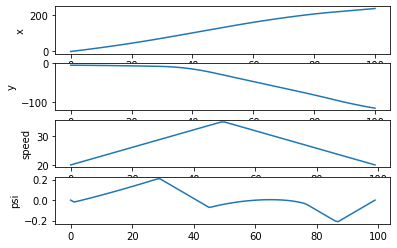

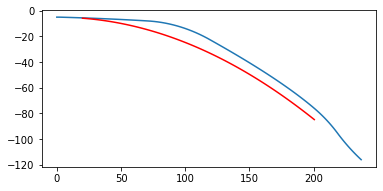

236.96695407846892 200.48399206907538
-115.9627070574487 -84.74860267948274
[9.35762296883931e-14, 9.41741603639511e-14, 9.772728159214575e-14, 1.046330150670014e-13, 1.1561203559505822e-13, 1.3184651474079756e-13, 1.552082414102527e-13, 1.8862094322212288e-13, 2.366692214055278e-13, 3.0663188299376883e-13, 4.1026321616749644e-13, 5.669213407731676e-13, 8.091747005030778e-13, 1.1930658882568585e-12, 1.8173209087706214e-12, 2.8601269810307942e-12, 4.65120983965368e-12, 7.816509901322725e-12, 1.3575771658707351e-11, 2.437014797681626e-11, 4.521994675193116e-11, 8.673918372964643e-11, 1.7200778595373877e-10, 3.5266420330852945e-10, 7.476306286154349e-10, 1.63891371120404e-09, 3.715336901904652e-09, 8.710482172758181e-09, 2.1121065898418914e-08, 5.297193679131759e-08, 1.372981112489891e-07, 3.6586082965524347e-07, 9.999257431581995e-07, 2.796140330530985e-06, 7.979980099148627e-06, 2.3183736455027232e-05, 6.838563582988865e-05, 0.00020425477266249433, 0.0006159747809930793, 0.0018694650317

In [ ]:
# MPC Trajectory Follower

import matplotlib.pyplot as plt
import numpy as np 
import pyomo.environ as pyo
from mpl_toolkits import mplot3d

# Simulation Parameters:
Ts = 0.1
N = 100
Nz = 2
Nu = 2

def getMidLaneY(x):
  return -x**2*0.002

def getTangent(x):
  dx = 0.01
  return pyo.atan((getMidLaneY(x + dx) - getMidLaneY(x - dx))/(2.*dx)) 

def getLaneOffsetY(x, y):
  return getMidLaneY(x) + y/pyo.cos(getTangent(x))

# Initial States:
laneWidth = 10
initEgoState = [0, getLaneOffsetY(0, -laneWidth/2.)]
initEgoControl = [20, 0]
initObsState = [20, getLaneOffsetY(20, -laneWidth/2.)]
initObsControl = [20, 0]

# Define Obstacle State:
obsState = np.zeros((2, N+1))
obsControl = np.zeros((2, N+1))

for i in range(N + 1):
  obsControl[0, i] = initObsControl[0]
  obsControl[1, i] = initObsControl[1]
  if i == 0:
    obsState[0, i] = initObsState[0]
    obsState[1, i] = initObsState[1]
  else:
    obsState[0, i] = obsState[0, i-1] + (obsControl[0, i] * Ts)*(np.cos(getTangent(obsState[0, i-1])))
    obsState[1, i] = obsState[1, i-1] + (obsControl[0, i] * Ts)*(np.sin(getTangent(obsState[0, i-1])))
    getTangent(obsState[0, i])

# Model Intitialize:
model = pyo.ConcreteModel()
model.tidx = pyo.Set(initialize=range(0, N + 1)) 
model.zidx = pyo.Set(initialize=range(0, Nz))
model.uidx = pyo.Set(initialize=range(0, Nu))

# Create state and input variables trajectory:
model.z = pyo.Var(model.zidx, model.tidx)
model.u = pyo.Var(model.uidx, model.tidx)
model.o = pyo.Var(model.tidx, initialize=0)

# Objective: TODO orientation cost, overtaking
model.cost = pyo.Objective(expr = 10. * (model.z[1, N] - getLaneOffsetY(model.z[0, N], -laneWidth/2.))**2 + 1. * (model.u[0, N-1] - initEgoControl[0])**2 + #10. * (model.z[1, N] - model.z[1, N-1])**2
                           + 0.05 * sum((model.u[1, t+1] - model.u[1, t])**2 for t in model.tidx if t < N-1)
                           - 10.0 * sum( model.z[0, t] - obsState[0, t] for t in model.tidx if t < N)
                           + 0.15 * sum((model.z[1, t] - getLaneOffsetY(model.z[0, t], -laneWidth/2.))**2 * (model.o[t])  for t in model.tidx if t < N)
                           + 0.02 * sum((model.z[1, t] - getLaneOffsetY(model.z[0, t], laneWidth/2.))**2 * (1 - model.o[t])  for t in model.tidx if t < N), sense=pyo.minimize)

# Initial Constraints: DONE
model.c1 = pyo.Constraint(model.zidx, rule=lambda model, i: model.z[i, 0] == initEgoState[i])
model.c2 = pyo.Constraint(model.uidx, rule=lambda model, j: model.u[j, 0] == initEgoControl[j])

# Model Constraints: TODO
model.c3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[0, t+1] == model.z[0, t] + model.u[0, t] * pyo.cos(model.u[1, t] + getTangent(model.z[0, t])) * Ts if t < N else pyo.Constraint.Skip)
model.c4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t+1] == model.z[1, t] + model.u[0, t] * pyo.sin(model.u[1, t] + getTangent(model.z[0, t])) * Ts if t < N else pyo.Constraint.Skip) 
 
# Speed & Acceleration Constraints: DONE
model.c5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] <= 35 if t < N else pyo.Constraint.Skip)
model.c6 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] >= initObsControl[0] if t < N else pyo.Constraint.Skip)
model.c7 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t+1] - model.u[0, t] >= -3 * Ts if t < N-1 else pyo.Constraint.Skip)
model.c8 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t+1] - model.u[0, t] <= 3 * Ts if t < N-1 else pyo.Constraint.Skip)

# Angle and Angular Speed Constraints: DONE
model.c9 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] >= -0.5 if t < N else pyo.Constraint.Skip)
model.c10 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] <= 0.5 if t < N else pyo.Constraint.Skip)
model.c11 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t+1] - model.u[1, t] >= -0.175 * Ts if t < N-1 else pyo.Constraint.Skip)
model.c12 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t+1] - model.u[1, t] <= 0.175 * Ts if t < N-1 else pyo.Constraint.Skip)

# Obstacle Constraints: DONE
model.c13 = pyo.Constraint(model.tidx, rule=lambda model, t: (model.z[0, t] - obsState[0, t])**2 + (model.z[1, t] - obsState[1, t])**2 >= 100 if t < N else pyo.Constraint.Skip)

# Lane Constraints: DONE
model.c14 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t] <= getLaneOffsetY(model.z[0, t], laneWidth))
model.c15 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t] >= getLaneOffsetY(model.z[0, t], -laneWidth))

# Overtaking Constraint: TODO 
model.c16 = pyo.Constraint(model.tidx, rule=lambda model, t: model.o[t] == 1/(1 + np.e**-(model.z[0, t] - obsState[0, t] - 10.)))

# Final Constraints: DONE
#model.c17 = pyo.Constraint(expr = model.z[1, N] <= getLaneOffsetY(model.z[0, N], -laneWidth/2.) + 2)
#model.c18 = pyo.Constraint(expr = model.z[1, N] >= getLaneOffsetY(model.z[0, N], -laneWidth/2.) - 2)
model.c19 = pyo.Constraint(model.uidx, rule=lambda model, j: model.u[j, N-1] == initEgoControl[j])

# Plot Results:
results = pyo.SolverFactory('ipopt').solve(model).write()

print(results)

egoXData = []
egoYData = []
egoVData = []
egoPData = []

for t in model.tidx:
  if t < (N+1):
      egoXData.append(pyo.value(model.z[0,t]))
      egoYData.append(pyo.value(model.z[1,t]))
  if t < N:
      egoVData.append(pyo.value(model.u[0,t]))
      egoPData.append(pyo.value(model.u[1,t]))

plt.figure()
plt.subplot(4,1,1)
plt.plot(egoXData)
plt.ylabel('x')
plt.subplot(4,1,2)
plt.plot(egoYData)
plt.ylabel('y')
plt.subplot(4,1,3)
plt.plot(egoVData)
plt.ylabel('speed')
plt.subplot(4,1,4)
plt.plot(egoPData)
plt.ylabel('psi')
plt.show()
plt.plot(egoXData,egoYData)
plt.plot(obsState[0,:],obsState[1,:],'r-')
plt.axis('scaled')
plt.show()

print(egoXData[N], obsState[0, N])
print(egoYData[N], obsState[1, N])
print(pyo.value(model.o[:]))

KeyboardInterrupt: ignored

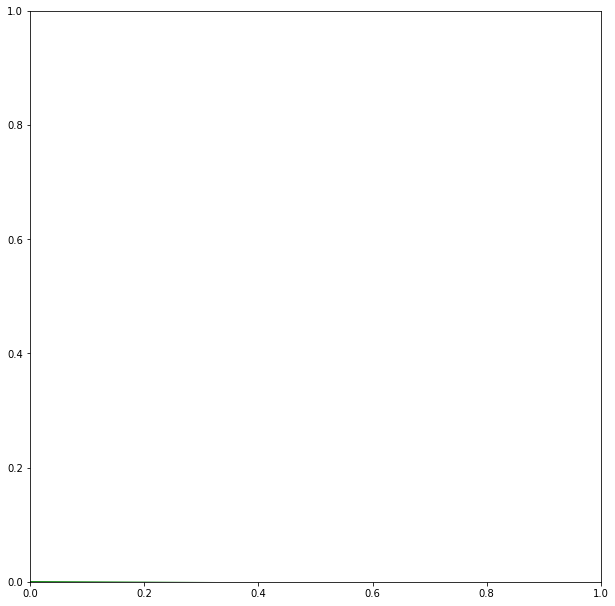

In [ ]:
# Trajectory Following Animation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from random import randint
from matplotlib import rc
import matplotlib as mpl
rc('animation', html='jshtml')

width = 2
length = 4.5

fig, ax = plt.subplots()

egoX = []
egoY = []

obsX = []
obsY = []

lowerLaneX = np.linspace(start=egoXData[0]-5, stop=egoXData[N]+5, num=100)
lowerLaneY = np.zeros(lowerLaneX.size)

middleLaneX = np.linspace(start=egoXData[0]-5, stop=egoXData[N]+5, num=100)
middleLaneY = np.zeros(lowerLaneX.size)

upperLaneX = np.linspace(start=egoXData[0]-5, stop=egoXData[N]+5, num=100)
upperLaneY = np.zeros(lowerLaneX.size)

for i in range(100):
  lowerLaneY[i] = getLaneOffsetY(lowerLaneX[i], -laneWidth)
  middleLaneY[i] = getLaneOffsetY(middleLaneX[i], 0.)
  upperLaneY[i] = getLaneOffsetY(upperLaneX[i], laneWidth)

def animate(i):
    egoX.append(egoXData[i])
    egoY.append(egoYData[i])

    obsX.append(obsState[0, i])
    obsY.append(obsState[1, i])
    ax.clear()
    ax.plot(obsX, obsY, c='r')
    r1 = Rectangle((egoX[-1]-length/2, egoY[-1]-width/2), length, width)
    t1 = mpl.transforms.Affine2D().rotate_deg_around(egoX[-1], egoY[-1], (getTangent(egoX[-1]) + egoPData[i])*180/np.pi) + ax.transData
    r1.set_transform(t1) 
    ax.add_patch(r1)
    ax.plot(egoX, egoY, c='b')
    r2 = Rectangle((obsX[-1]-length/2, obsY[-1]-width/2), length, width)
    t2 = mpl.transforms.Affine2D().rotate_deg_around(obsX[-1], obsY[-1], getTangent(obsX[-1])*180/np.pi) + ax.transData
    r2.set_transform(t2) 
    ax.add_patch(r2)
    ax.plot(lowerLaneX, lowerLaneY, c='g')
    ax.plot(middleLaneX, middleLaneY, c='g')
    ax.plot(upperLaneX, upperLaneY, c='g')
    fig.set_size_inches(10.5, 10.5)
    plt.gca().set_aspect(1)
  
ani = FuncAnimation(fig, animate, frames=N, interval=100, repeat=False)
ani

In [ ]:
egoXdata = np.array(egoXData)
egoXdata = egoXdata.reshape((1,N+1))
egoYdata = np.array(egoYData)
egoYdata = egoYdata.reshape((1,N+1))
egoVdata = np.array(egoVData)
egoVdata = np.append(egoVdata,egoVData[-1])
egoVdata = egoVdata.reshape((1,N+1))
egoPdata = np.array(egoPData)
egoPdata = np.append(egoPdata,egoPData[-1])
egoPdata = egoPdata.reshape((1,N+1))
combined_state_data1 = np.concatenate((egoXdata, egoYdata))
combined_state_data2 = np.concatenate((egoVdata, egoPdata))
combined_state_data = np.concatenate((combined_state_data1,combined_state_data2))

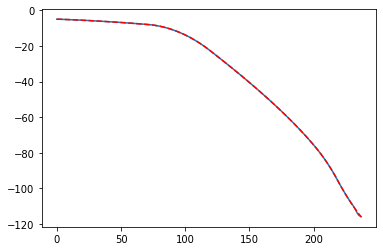

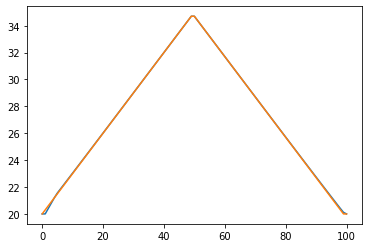

In [ ]:
# Comparison Between Open Loop and Closed Loop Trajectories

nz = 4        # number of states
nu = 2         # number of inputs

l_r   = 1.738                  
def solve_cftoc(Ts,Nmodel,nz,nu,x0,u0,stateData):
    model = pyo.ConcreteModel()
    model.tidx = pyo.Set(initialize=range(0, Nmodel+1)) # length of finite optimization problem
    model.zidx = pyo.Set(initialize=range(0, nz))
    model.uidx = pyo.Set(initialize=range(0, nu))

    # Create state and input variables trajectory:
    model.z = pyo.Var(model.zidx, model.tidx)
    model.u = pyo.Var(model.uidx, model.tidx)

    # Objective:
    model.cost = pyo.Objective(expr = 10.0*sum((model.z[i, Nmodel] - stateData[i,-1])**2 for i in model.zidx) + sum((model.z[0, t] - stateData[0,t])**2 + (model.z[1, t] - stateData[1,t])**2 + (model.z[2, t] - stateData[2,t])**2 for t in model.tidx), sense=pyo.minimize)

    # Constraints:

    model.constraint1 = pyo.Constraint(model.zidx, rule=lambda model, i: model.z[i, 0] == x0[i])
    model.constraint2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[0, t+1] == model.z[0, t] + Ts*(model.z[2, t]*pyo.cos(model.z[3, t] + model.u[1, t]))
                                      if t < Nmodel else pyo.Constraint.Skip)
    model.constraint3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t+1] == model.z[1, t] + Ts*(model.z[2, t]*pyo.sin(model.z[3, t] + model.u[1, t]))
                                      if t < Nmodel else pyo.Constraint.Skip)
    model.constraint4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[2, t+1] == model.z[2, t] + Ts*model.u[0, t]
                                      if t < Nmodel else pyo.Constraint.Skip)
    model.constraint5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[3, t+1] == model.z[3, t] + Ts*(model.z[2, t]/l_r*pyo.sin(model.u[1, t]))
                                      if t < Nmodel else pyo.Constraint.Skip)
    model.constraint6 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] <= 4 
                                    if t < Nmodel else pyo.Constraint.Skip)
    model.constraint7 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] >= -4
                                    if t < Nmodel else pyo.Constraint.Skip)
    model.constraint8 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t+1] - model.u[1, t] <= 0.2
                                      if t < Nmodel-1 else pyo.Constraint.Skip)
    model.constraint9 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t+1] - model.u[1, t] >= -0.2
                                      if t < Nmodel-1 else pyo.Constraint.Skip)
    model.constraint10 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] >= -0.6
                                      if t < Nmodel else pyo.Constraint.Skip)
    model.constraint11 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] <= 0.6
                                      if t < Nmodel else pyo.Constraint.Skip) 
    model.constraint12 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[2, t] <= 50
                                      if t < Nmodel else pyo.Constraint.Skip)
    model.constraint13 = pyo.Constraint(model.uidx, rule=lambda model, i: model.u[i, 0] == u0[i])

                                                           

    # Now we can solve:
    results = pyo.SolverFactory('ipopt').solve(model)

    xOpt = np.asarray([[model.z[i,t]() for i in model.zidx] for t in model.tidx]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tidx]).T
    return [model, xOpt, uOpt]

xOpt = combined_state_data[:,0]
uOpt = np.array([0., 0.])
[a,b,c] = solve_cftoc(Ts,N,nz,nu,xOpt,uOpt, combined_state_data)
plt.plot(b[0,:],b[1,:])
plt.plot(combined_state_data[0,:],combined_state_data[1,:],'r--')
plt.show()
plt.plot(b[2,:])
plt.plot(combined_state_data[2,:])
plt.show()

0 10 11
1 10 12
2 10 13
3 10 14
4 10 15
5 10 16
6 10 17
7 10 18
8 10 19
9 10 20
10 10 21
11 10 22
12 10 23
13 10 24
14 10 25
15 10 26
16 10 27
17 10 28
18 10 29
19 10 30
20 10 31
21 10 32
22 10 33
23 10 34
24 10 35
25 10 36
26 10 37
27 10 38
28 10 39
29 10 40
30 10 41
31 10 42
32 10 43
33 10 44
34 10 45
35 10 46
36 10 47
37 10 48
38 10 49
39 10 50
40 10 51
41 10 52
42 10 53
43 10 54
44 10 55
45 10 56
46 10 57
47 10 58
48 10 59
49 10 60
50 10 61
51 10 62
52 10 63
53 10 64
54 10 65
55 10 66
56 10 67
57 10 68
58 10 69
59 10 70
60 10 71
61 10 72
62 10 73
63 10 74
64 10 75
65 10 76
66 10 77
67 10 78
68 10 79
69 10 80
70 10 81
71 10 82
72 10 83
73 10 84
74 10 85
75 10 86
76 10 87
77 10 88
78 10 89
79 10 90
80 10 91
81 10 92
82 10 93
83 10 94
84 10 95
85 10 96
86 10 97
87 10 98
88 10 99
89 10 100
90 10 100
91 9 100
92 8 100
93 7 100
94 6 100
95 5 100
96 4 100
97 3 100
98 2 100
99 1 100
ERROR: Rule failed when generating expression for Constraint constraint13 with
    index 0: ValueError: Cons

ValueError: ignored

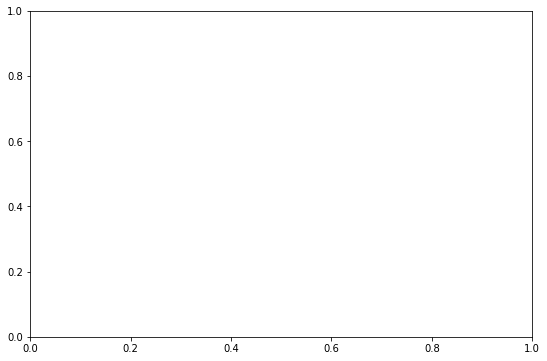

In [ ]:
M = 50  # Simulation steps
xOpt = np.zeros((4, N+1))
xOpt[:,0] = combined_state_data[:,0]
uOpt = np.zeros((2, N+1))
uOpt[:,0] = np.array([0., 0.])
fig = plt.figure(figsize=(9, 6))
for t in range(0,100):
  print(t, min(10, 100-t), min(t+11, N))
  [model, x, u] = solve_cftoc(Ts,min(10, 99-t),nz,nu,xOpt[:,t], uOpt[:, t],combined_state_data[:,t:min(t+11, N)])

  # Save closed loop trajectory
  # Note that the second column of x represents the optimal closed loop state
  xOpt[:,t+1] = x[:, 1]
  if t%30 == 0:
    xOpt[:, t+1] = xOpt[:, t+1] + (0.5 - np.random.random((4,)))
    plt.arrow(x=xOpt[0, t], y=xOpt[1, t]+20, dx=0, dy=-10, width=.5, facecolor='red') 
  uOpt[:,t+1] = u[:, 1]
#for t in range(10,20):
#  print(t)
  # print(N-t)
#  [model, x, u] = solve_cftoc(Ts,10,nz,nu,xOpt[:,t], uOpt[:, t],combined_state_data[:,t:t+11])
  # plt.plot(x[0,:],x[1,:])
  # plt.show()
#  xOpt[:,t+1] = x[:, 1]
#  uOpt[:,t+1] = u[:, 1]

# Plot Open Loop
line1 = plt.plot(combined_state_data[0,:], combined_state_data[1,:], 'r--')
# Plot Closed Loop
line2 = plt.plot(xOpt[0, :], xOpt[1,:], 'b-')
#line2 = plt.plot(xOpt[0, 30], xOpt[1,30], '-')

print(xOpt[0, 30], xOpt[1, 30])
#plt.arrow(xOpt[0, 30], xOpt[1, 30], 20, 20, width = 1)
#plt.arrow(1, -0.00010, 0, -0.00005, length_includes_head=True,
#          head_width=0.08, head_length=0.00002)


plt.legend(['Closed-loop','Open Loop']);
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

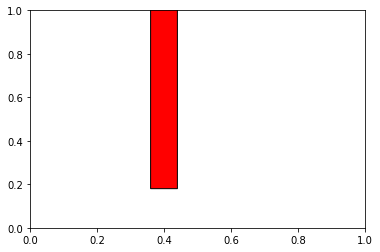

In [ ]:
plt.arrow(x=.4, y=.18, dx=0, dy=5, width=.08, facecolor='red') 
plt.show()